In [1]:
using Fretem, Potential, Alphabeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling Alphabeta [1981c01b-18a7-44d8-b572-49586e674f9d]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [4]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration

# Define Physical Domain
xratio = 20 # unit: angstrom
xavg = 50   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [5]:
k_eq = 0.5 # unit: kcal/mol/angstrom^2
sigma_by_keq = 1 / sqrt(2 * k_eq)
V_eq = harmonic_well_k_mean(xref, k_eq, xavg)
rho_eq = get_rhoeq(V_eq, w0)
peq = rho_eq .* rho_eq
D = 4.845e9 # Diffusion coefficient, unit: angstrom^2 s-1
## Photon Operator
k_photon = 3. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 3: Read Trajectory

#### physical parameters about simulations

In [6]:
save_freq = 1e-9 # unit: s, Save trajectory per 100 ps
total_times = 10e-6 # unit: s, totol simulate 10 us, 10e-6
dt = 1e-11 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [7]:
f_in = "../trajectory/k_1_tsim_10us_deltat_1ns.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D"); # Diffusion coefficient, unit: angstrom^2 s-1

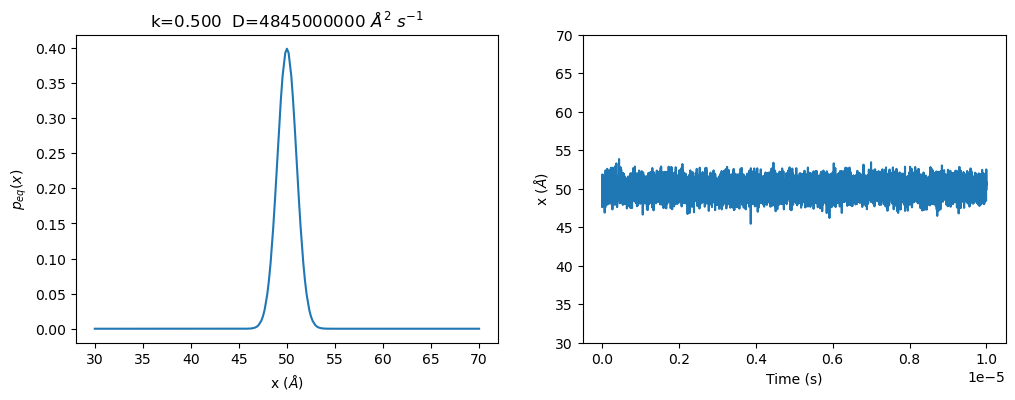

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, rho_eq .* rho_eq)
ax.set_xlabel("x (\$ \\AA \$)")
ax.set_ylabel("\$ p_{eq}(x) \$")
title = @sprintf "k=%.3f  D=%.0f \$\\AA^2~ s^{-1}\$" k_ref D
ax.set_title(title)

ax = axes[2]
ax.plot(t_record, y_record)
ax.set_xlabel("Time (s)")
ax.set_ylabel("x (\$ \\AA \$)")
ax.set_ylim(30,70)
#plt.savefig("Simu_for_EM.png", dpi=200)
plt.show()

### Part 4: Get eigenvalues and eigenvectors

In [8]:
Nv = 72 # Number of eigenvectors
Lambdas, Qx, rho = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, peq, D, Nv)
weight_Qx = get_weight_Qx(N, Nv, w0, Qx);

In [11]:
expLQDT = exp.(-Lambdas .* save_freq);

In [12]:
typeof(expLQDT)

Array{Float64,1}

### Part 5: Forward algorithm

In [7]:
scale_factor_array = zeros(4)

alpha_t0 = get_alpha_t0(weight_Qx, rho_eq)
alpha_t0_e_delta_t = get_alpha_hat_e_delta_t(Lambdas, save_freq, alpha_t0)

photon_id = 1 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx

alpha_t1_before_normalize = psi_photon_psi * alpha_t0_e_delta_t
scale_factor_array[photon_id] = norm(alpha_t1_before_normalize)
alpha_t1_hat = alpha_t1_before_normalize ./ scale_factor_array[photon_id]
alpha_t1_hat_e_delta_t = get_alpha_hat_e_delta_t(Lambdas, save_freq, alpha_t1_hat)

photon_id = 2 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx

alpha_t2_before_normalize = psi_photon_psi * alpha_t1_hat_e_delta_t
scale_factor_array[photon_id] = norm(alpha_t2_before_normalize)
alpha_t2_hat = alpha_t2_before_normalize ./ scale_factor_array[photon_id]
alpha_t2_hat_e_delta_t = get_alpha_hat_e_delta_t(Lambdas, save_freq, alpha_t2_hat)

photon_id = 3 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx;

alpha_t3_before_normalize = psi_photon_psi * alpha_t2_hat_e_delta_t
scale_factor_array[photon_id] = norm(alpha_t3_before_normalize)
alpha_t3_hat = alpha_t3_before_normalize ./ norm(scale_factor_array[photon_id])
alpha_t3_hat_e_delta_t = get_alpha_hat_e_delta_t(Lambdas, save_freq, alpha_t3_hat)

photon_id = 4 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx

alpha_t4_before_normalize = psi_photon_psi * alpha_t3_hat_e_delta_t
scale_factor_array[photon_id] = norm(alpha_t4_before_normalize)
alpha_t4_hat = alpha_t4_before_normalize ./ scale_factor_array[photon_id];

### Part 6-1: Plot $ \left| \beta_{t_4} \right>$

In [8]:
beta_t4 = get_beta_T(Nv, weight_Qx);

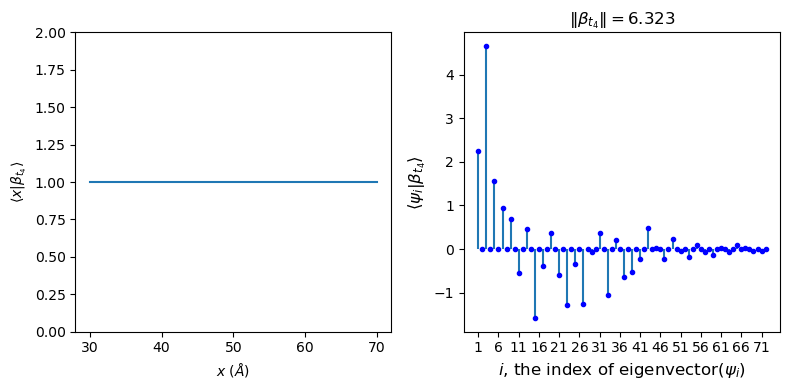

In [9]:
fig, axes = plot_beta_T(xref, beta_t4)
plt.tight_layout()
#plt.savefig("beta_t4.png", dpi=150)
plt.show()

### Part 6-2: $p(x_4|\textbf{y})$

In [32]:
posterior = (Qx * alpha_t4_hat).^2;

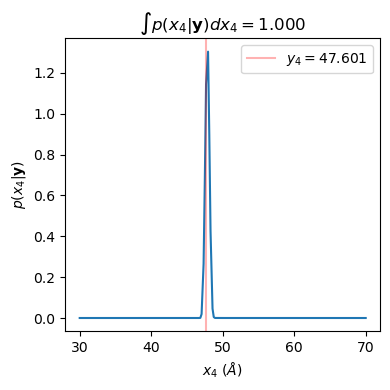

In [35]:
fig, ax = plt.subplots(figsize=(4,4))
photon_id = 4
ax.plot(xref, posterior)
xlabel = @sprintf "\$ x_{%d} \$ (\$ \\AA \$)" photon_id
ax.set_xlabel(xlabel)
ylabel = @sprintf "\$p(x_{%d}|\\mathbf{y})\$" photon_id
ax.set_ylabel(ylabel)
label = @sprintf "\$y_{%d}=%.3f\$" photon_id y_record[photon_id+1]
ax.axvline(y_record[photon_id+1], color="red", alpha=0.3, label=label)
title = @sprintf "\$\\int p(x_{%d}|\\mathbf{y}) dx_{%d} = %.3f\$" photon_id photon_id sum(w0 .* posterior)
ax.set_title(title)
ax.legend()

plt.tight_layout()
#plt.savefig("posterior_4.png", dpi=150)
plt.show()

### Part 7-1: Plot $ \left| \beta_{t_3} \right>$

In [9]:
photon_id = 4 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx;

In [10]:
y_beta_t4 = psi_photon_psi * beta_t4
beta_t3 = get_e_delta_t_y_beta(Lambdas, save_freq, y_beta_t4);

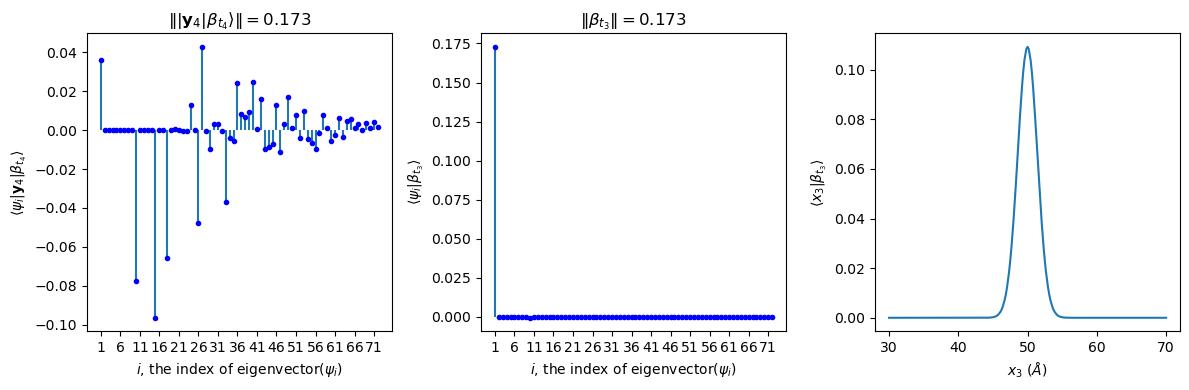

In [11]:
fig, axes = plot_beta_T_minus_1(y_beta_t4, beta_t3, photon_id, xref, Qx)
plt.tight_layout()
#plt.savefig("beta_3.png", dpi=150)
plt.show()

### Part 7-2: Plot $ \left| \hat{\beta}_{t_3} \right>$ and $p(x_3|\textbf{y})$

In [11]:
beta_t3_hat = get_normalized_beta(beta_t3, photon_id, scale_factor_array, Qx, alpha_t3_hat, w0)
posterior = get_posterior(alpha_t3_hat, beta_t3_hat, Qx);

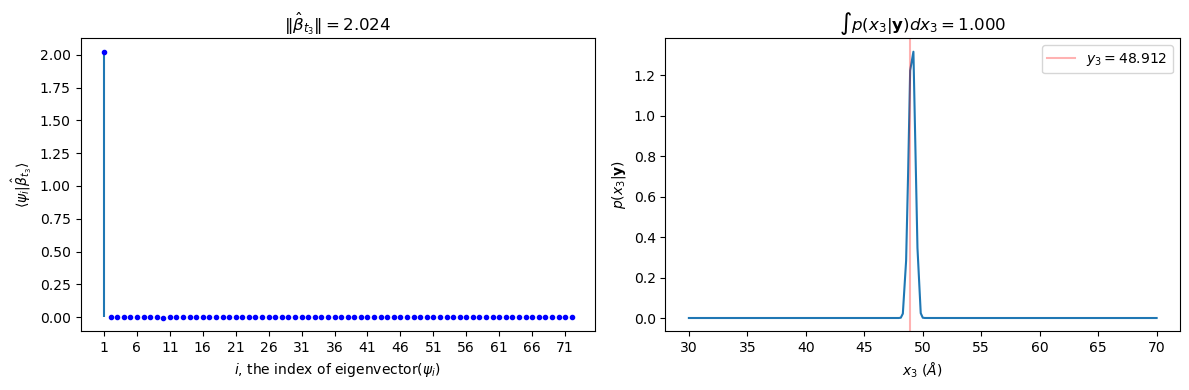

In [16]:
fig, axes = plot_beta_hat_posterior(xref, beta_t3_hat, posterior, photon_id, w0, y_record[photon_id])
plt.tight_layout()
#plt.savefig("beta_3_hat.png", dpi=150)
plt.show()

### Part 8: Plot $ \left| \hat{\beta}_{t_2} \right>$ and $p(x_2|\textbf{y})$

In [17]:
photon_id = 3 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx;

In [18]:
y_beta_t3_hat = psi_photon_psi * beta_t3_hat
e_delta_t_y_beta_t3_hat = get_e_delta_t_y_beta(Lambdas, save_freq, y_beta_t3_hat);

In [19]:
beta_t2_hat = get_normalized_beta(e_delta_t_y_beta_t3_hat, photon_id, scale_factor_array, Qx, alpha_t2_hat, w0);
posterior = get_posterior(alpha_t2_hat, beta_t2_hat, Qx);

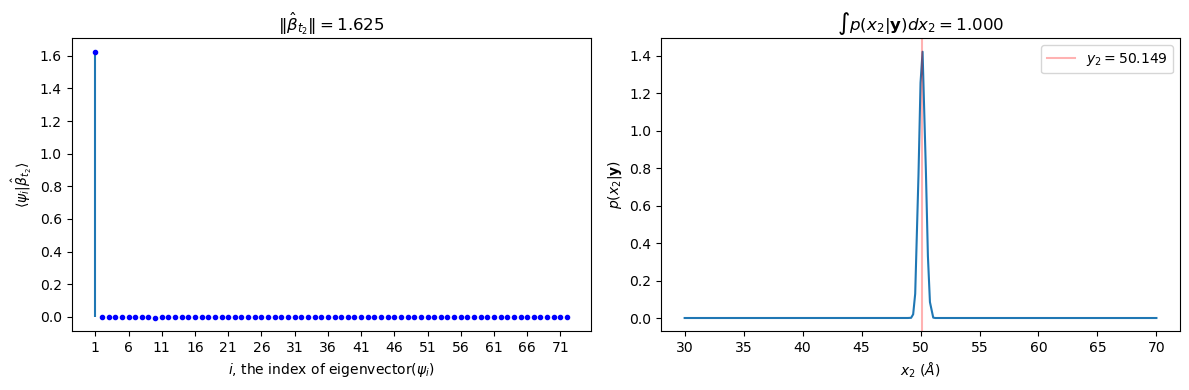

In [21]:
fig, axes = plot_beta_hat_posterior(xref, beta_t2_hat, posterior, photon_id, w0, y_record[photon_id])
plt.tight_layout()
#plt.savefig("beta_2_hat.png", dpi=150)
plt.show()

### Part 9: Plot $ \left| \hat{\beta}_{t_1} \right>$ and $p(x_1|\textbf{y})$

In [22]:
photon_id = 2 # Ad hoc
y = y_record[photon_id+1]
photon_mat = get_photon_matrix_gaussian(y, xref, e_norm, interpo_xs, Np, w0, k_photon)
psi_photon_psi = Qx' * photon_mat * Qx;

In [23]:
y_beta_t2_hat = psi_photon_psi * beta_t2_hat
e_delta_t_y_beta_t2_hat = get_e_delta_t_y_beta(Lambdas, save_freq, y_beta_t2_hat);

In [24]:
beta_t1_hat = get_normalized_beta(e_delta_t_y_beta_t2_hat, photon_id, scale_factor_array, Qx, alpha_t1_hat, w0);
posterior = get_posterior(alpha_t1_hat, beta_t1_hat, Qx);

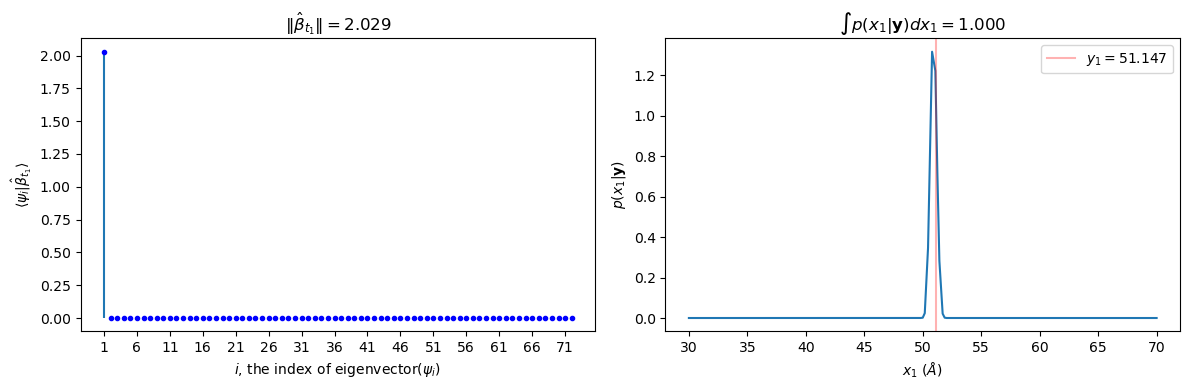

In [26]:
fig, axes = plot_beta_hat_posterior(xref, beta_t1_hat, posterior, photon_id, w0, y_record[photon_id])
plt.tight_layout()
#plt.savefig("beta_1_hat.png", dpi=150)
plt.show()